In [77]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
from sklearn.preprocessing import normalize
from scipy import signal
import skimage
import tifffile as tiff
import os
import math
import json
from skimage.measure import label
from skimage.measure import regionprops
from com import *
import csv
from tqdm.notebook import tqdm
from skeleton import *
%config Completer.use_jedi = False

In [47]:
imgspath = "/media/isis0517/QVO2/0115/03"
savepath = "/home/isis0517/Videos"
    

flist = os.listdir(imgspath)
tiflist = []
for filename in flist:
    if os.path.isdir(filename):
        continue
    if filename.split(".")[-1] == "npy" :
        tiflist.append(filename)

print('There is a total of ',len(tiflist), 'images')
frame_num = len(tiflist)
#for srt in os.listdir(path):
#flist.append(srt.split('_'))

#排序路徑
tiflist.sort(key = lambda x: int(x.split("_")[-1].split(".")[0]))

#變成絕對路徑
flist = []
for filename in tiflist:
    flist.append(os.path.join(imgspath, filename))


There is a total of  23430 images


take only 23400 frames in origin data


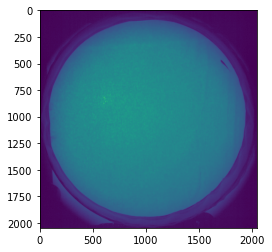

In [53]:
plt.imshow(np.load(flist[23400]))
flist = flist[:23400]
print(f"take only {len(flist)} frames in origin data")

# Generate the background

  0%|          | 0/500 [00:00<?, ?it/s]

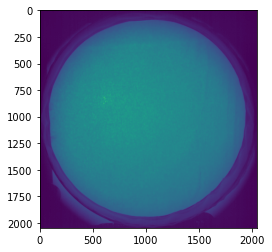

In [54]:

nbckgnd = 500
tnum = np.random.randint(len(flist),size=nbckgnd)
tlist=[]
for s in tnum:
    tlist.append(flist[s])

img_shape = np.load(flist[0]).shape
total = np.zeros(img_shape)
for file in tqdm(tlist):
    img = np.load(file)
    #img = cv2.blur(b, (3,3))
    #img = cv2.blur(img)
    total = total + img
background = (total/nbckgnd).astype('uint8')
cbackground = background
shape = img_shape
plt.imshow(background)

In [12]:
mask = np.full(background.shape[0:2], True)

# Get position

  0%|          | 0/23400 [00:00<?, ?it/s]

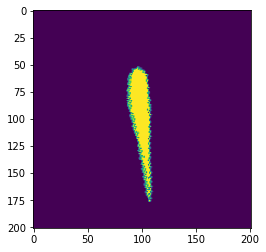

In [55]:

from skimage.measure import label

img =np.load(flist[0])
size = 100 #cv2.VideoWriter_fourcc(*'MPEG')
video = cv2.VideoWriter(os.path.join(savepath, "path_video03.avi"), cv2.VideoWriter_fourcc(*'MPEG'),
                        40, (size*2+1, size*2+1), isColor=False)

abs_lim = 20
poses = []
for filename in tqdm(flist):
    img = np.load(filename)
    img = cv2.absdiff(img, background)
    img = img*mask
    img = np.where(img>abs_lim, 255, 0).astype('uint8')
    pos = get_pos(img)
    img = cutting_img(img, pos, size)
    
    labels = label(img, connectivity=2, background=False)
    group = regionprops(labels)

    index = 0
    area = 0
    for com in group:
        if com.area > area:
            index = com.label
            area = com.area
    img = np.where(labels==index, 255, 0).astype('uint8')
    
    try:
        sk = NT_skeleton(img)
    except Exception as e:
        print(s, e)
        break
    
    v1 = sk[0]-sk[2]
    a = v1/np.linalg.norm(v1, ord=2)
    b = np.array([1,0])
    c = a-b
    angle = 2*np.arcsin(np.linalg.norm(c/2))
    if a[1]>0:
        angle = -angle
    if angle != angle:
        print("算錯啦")
        print(sk)
    M = cv2.getRotationMatrix2D((size, size), 180+angle/(np.pi)*180, 1)
    rotated = cv2.warpAffine(img, M, (2*size+1,2*size+1))
    break
    
plt.imshow(rotated)
        

In [56]:
%%time
from multiprocessing import Pool
from numba import jit, njit
from skimage.measure import label

abs_lim = 20
def multi_rot_imgs(filename, background, mask, abs_lim):
    size = 100
    img = np.load(filename)
    img = cv2.absdiff(img, background)
    img = img*mask
    img = np.where(img>abs_lim, 255, 0).astype('uint8')
    pos = get_pos(img)
    img = cutting_img(img, pos, size)
    
    labels = label(img, connectivity=2, background=False)
    group = regionprops(labels)

    index = 0
    area = 0
    for com in group:
        if com.area > area:
            index = com.label
            area = com.area
    img = np.where(labels==index, 255, 0).astype('uint8')
    
    try:
        sk = NT_skeleton(img)
    except Exception as e:
        print(s, e)
        return s
        
    v1 = sk[0]-sk[2]
    a = v1/np.linalg.norm(v1, ord=2)
    b = np.array([1,0])
    c = a-b
    angle = 2*np.arcsin(np.linalg.norm(c/2))
    if a[1]>0:
        angle = -angle
    if angle != angle:
        print("算錯啦")
        print(sk)
    M = cv2.getRotationMatrix2D((size, size), 180+angle/(np.pi)*180, 1)
    rotated = cv2.warpAffine(img, M, (2*size+1,2*size+1))
    
    return rotated, angle, pos


with Pool() as pool:
    map_arr = []
    for filename in flist:
        map_arr.append((filename, background, mask, abs_lim))
    print("pool start")
    result = pool.starmap(multi_rot_imgs, map_arr)

imgs = []
h_ans = []
poses = []
print("stop")
for temp in result:
    imgs.append(temp[0])
    h_ans.append(temp[1])
    poses.append(temp[2])

pool start
stop
CPU times: user 1.54 s, sys: 608 ms, total: 2.14 s
Wall time: 7min 57s


2.8685839505030835


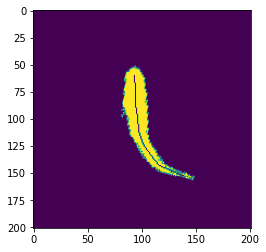

In [57]:
s = 17560   
sk = NT_skeleton(imgs[s], er_num=2, di_num=3)

print(h_ans[s])
draw = imgs[s].copy()
for n in range(len(sk)-1):
    cv2.line(draw, (sk[n, 1], sk[n, 0]), (sk[n+1, 1], sk[n+1, 0]), (0), 1)
plt.imshow(draw)
#plt.plot(*np.flip(sk, axis=1).T, lw=1.3, color='r')
#plt.axis('off')
#plt.imshow(np.load(os.path.join(imgspath, flist[s+data_len])))

## apply the eigenfish


In [58]:
def an2vec(an, r):
    x = np.cos(an)
    y = np.sin(an)
    return r*np.array([x,y])

def get_rot_M(angle):
    a = np.cos(angle)
    b = np.sin(angle)
    return np.array([[a,-b],[b,a]])

def an2ori(an_sk, vec=np.array([0,1]), intens=1):
    test_sk = [vec]
    for i in range(len(an_sk)):
        vec = np.dot(vec,get_rot_M(an_sk[i]*intens))
        test_sk.append(test_sk[-1]+vec)

    return np.array(test_sk)



han_sks=[]

for s, img in enumerate(tqdm(imgs)):
    
    sk = NT_skeleton(img, er_num=2, di_num=3)
    
    vec_sk = []
    for i in range(len(sk)-1):
        vec_sk.append(sk[i+1]-sk[i])
    if len(sk)<10:
        plt.imshow(imgs[s])
        print("sk error")
        print(s, NT_skeleton(imgs[s]))
        plt.show()
        break
    
    heading = vec_sk[0]
    han_sk=[]
    
    heading = heading/np.linalg.norm(heading)
    for vec in vec_sk[1:]:
        vec = vec/np.linalg.norm(vec)
        a = heading
        b = vec

        #根據和角公式 = sin(a-b) = sina cosb - cosa sinb
        #sin(angle) = a[1]b[0]-a[0]b[1]
        c = a-b
        angle = 2*np.arcsin(np.linalg.norm(c/2))
        if angle != angle:
            print("算錯啦")
            print(s, vec_sk)
            break
            
        err = b-np.dot(a, get_rot_M(angle))
        b_len = np.linalg.norm(b)
        while np.linalg.norm(err) > b_len*0.1:
            angle=-angle
            err = b-np.dot(a, get_rot_M(angle))
            
        han_sk.append(angle)
    han_sks.append(han_sk)
print(len(han_sks))    


## 20000張 1:25

  0%|          | 0/23400 [00:00<?, ?it/s]

23400


# apply PCA
    同時把position更新，以利於後面計算速度

[0.87922481 0.08253227 0.01341803] 0.9751751144082882


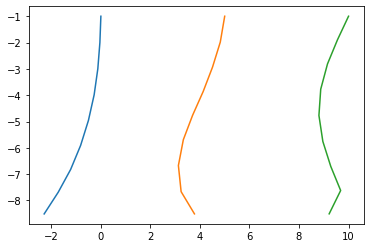

In [59]:

from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(han_sks)
pc1 = pca.components_[0]
u = np.array([0,-1])
n=0
for pcs in pca.components_:
    sk = [u]
    pcs = pcs*1
    for an in pcs:
        M = get_rot_M(an).T
        sk.append(sk[-1]+np.dot(M,u))
    sk = np.array(sk)
    plt.plot(sk[:,0]+n*5,sk[:,1])
    n+=1
print(pca.explained_variance_ratio_, np.sum(pca.explained_variance_ratio_))

pca_sks = pca.transform(han_sks)

# kmeans

左右相反
!注意! 不增加poses長度

In [60]:
from sklearn.cluster import KMeans

n_clusters = 25
pos_kmeans = KMeans(n_clusters=n_clusters, algorithm="elkan", init="k-means++", tol=1e-11, n_init=40)
pos_kmeans.fit(pca_sks)
labels = pos_kmeans.predict(pca_sks)
centers = pos_kmeans.cluster_centers_

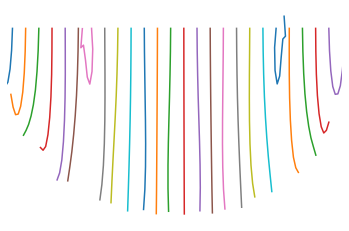

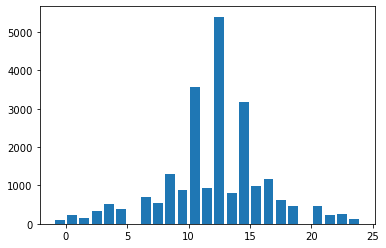

164


In [61]:
nums, bins = np.histogram(labels, bins=np.arange(n_clusters+1)-0.5)
ords = np.argsort(centers[:, 0])[::-1]
u = np.array([0,-1])

for s, pcas in enumerate(centers[ords]):
    sks = np.dot(pcas, pca.components_)
    sk=[np.array([0,-1])]
    for an in sks:
        M = get_rot_M(an).T
        sk.append(sk[-1]+np.dot(M,u))
    sk = np.array(sk)
    plt.plot(sk[:,0]+s*5,sk[:,1])
    n+=1
plt.axis('off')
plt.xlim([-2, n_clusters*5])
plt.show()
plt.bar(bins[:-1], nums[ords])
#plt.axis('off')
plt.show()
print(nums[ords[2]])

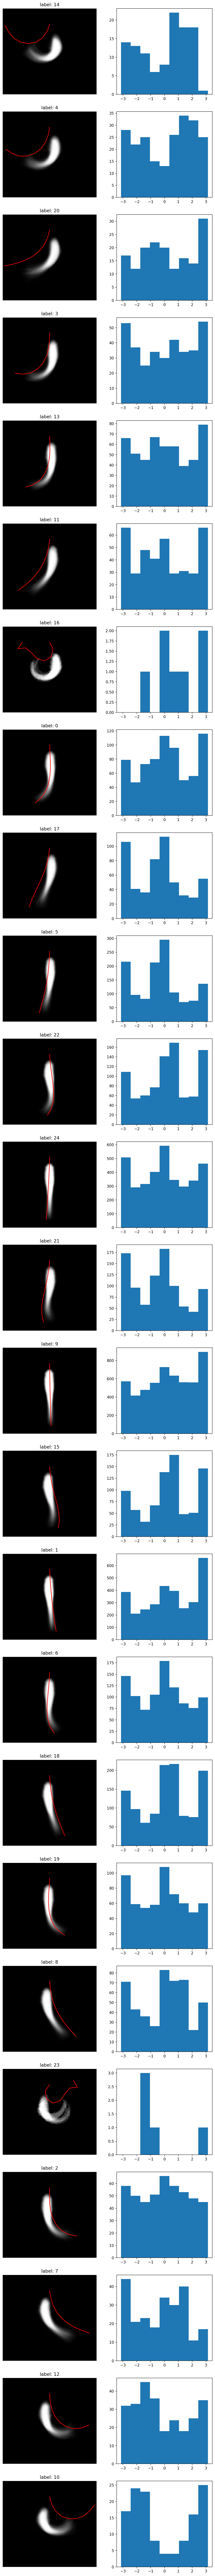

In [62]:
fig, axs = plt.subplots(pos_kmeans.n_clusters, 2, figsize=(10,5*pos_kmeans.n_clusters), dpi= 200)
ans = [list() for _ in range(pos_kmeans.n_clusters)]
cen_imgs = np.zeros((n_clusters, imgs[0].shape[0], imgs[0].shape[1]), dtype='int')

bins = np.linspace(-np.pi, np.pi, num=10)

for s, label in enumerate(labels):
    cen_imgs[label] += imgs[s]
    ans[label].append(h_ans[s])

for num, s in enumerate(ords):
    img = cen_imgs[s]
    cen_imgs[s] = (img/nums[s]).astype('uint8')
    #cv2.imwrite(os.path.join(savepath,f"centers_{s}.png"), img*255)
    
    sks = np.dot(centers[s], pca.components_)
    sk = [np.array([0,-2])]
    for an in sks:
        M = get_rot_M(an).T
        sk.append(sk[-1]+np.dot(M,sk[0]))
    sk = np.array(sk)
    
    axs[num, 0].imshow(cen_imgs[s], plt.cm.gray, extent=[-12, 12, -20, 2]) 
    axs[num, 0].title.set_text(f"label: {s}")
    axs[num, 0].plot(sk[:,0], sk[:,1], c='red')
    axs[num, 0].axis('Off')
    
    axs[num, 1].hist(ans[s], bins=bins)

# for s, _ in np.ndenumerate(axs):
#     axs[s].axis('Off')

7835


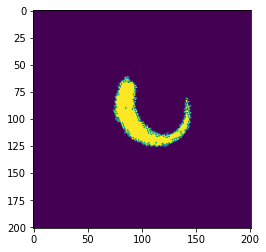

7836


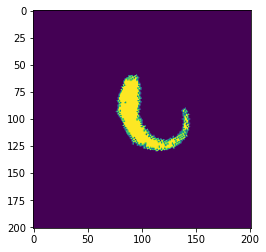

12804


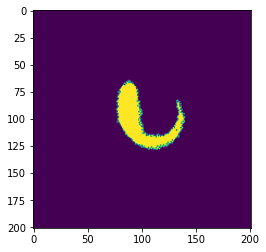

22033


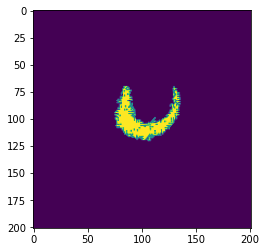

22951


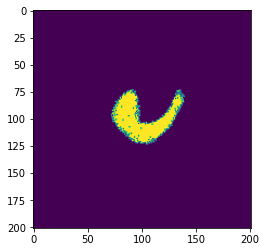

In [63]:
for s, label in enumerate(labels):
    if label == 23:
        plt.imshow(imgs[s])
        print(s)
        plt.show()

# get the speed

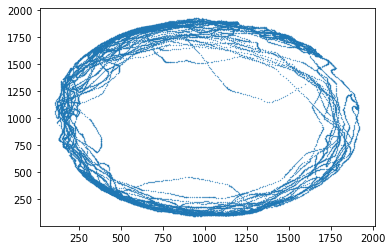

In [75]:
poses = np.array(poses)
plt.scatter(*poses.T, s=0.1)
velocity = (poses[1:]-poses[:-1])/2

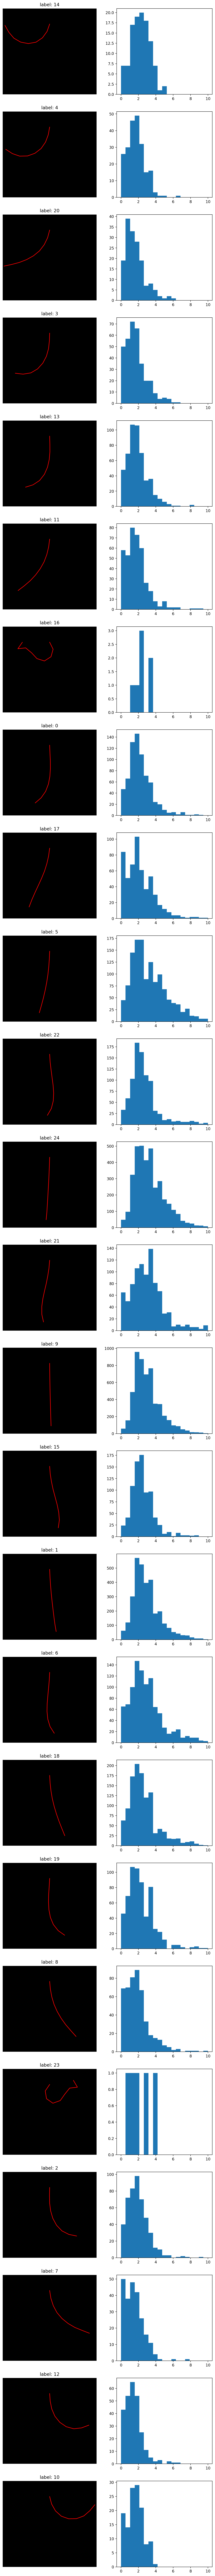

In [83]:
fig, axs = plt.subplots(pos_kmeans.n_clusters, 2, figsize=(10,5*pos_kmeans.n_clusters), dpi= 200)
ans = [list() for _ in range(pos_kmeans.n_clusters)]
cen_imgs = np.zeros((n_clusters, imgs[0].shape[0], imgs[0].shape[1]), dtype='int')

bins = np.linspace(0, 10, num=20)

speeds = [list() for _ in range(pos_kmeans.n_clusters)]

for s, num in enumerate(labels[0:-4]):
    s = s-2
    if s < 0:
        continue
    speeds[num].append(np.linalg.norm(velocity[s]))
    
for num, s in enumerate(ords):
    img = cen_imgs[s]
    cen_imgs[s] = (img/nums[s]).astype('uint8')
    #cv2.imwrite(os.path.join(savepath,f"centers_{s}.png"), img*255)
    
    sks = np.dot(centers[s], pca.components_)
    sk = [np.array([0,-2])]
    for an in sks:
        M = get_rot_M(an).T
        sk.append(sk[-1]+np.dot(M,sk[0]))
    sk = np.array(sk)
    
    axs[num, 0].imshow(cen_imgs[s], plt.cm.gray, extent=[-12, 12, -20, 2]) 
    axs[num, 0].title.set_text(f"label: {s}")
    axs[num, 0].plot(sk[:,0], sk[:,1], c='red')
    axs[num, 0].axis('Off')
    
    axs[num, 1].hist(speeds[s], bins=bins)

[0.8383077  0.1076796  0.02746512] 0.9734524262843809


array([-0.70638786, -0.09803961, -0.26151121])

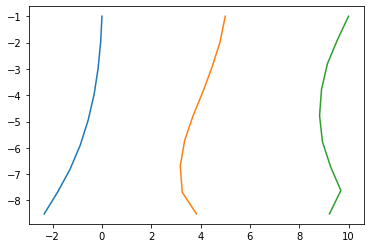

In [35]:

from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(han_sks)
pc1 = pca.components_[0]
u = np.array([0,-1])
n=0
for pcs in pca.components_:
    sk = [u]
    pcs = pcs*1
    for an in pcs:
        M = get_rot_M(an).T
        sk.append(sk[-1]+np.dot(M,u))
    sk = np.array(sk)
    plt.plot(sk[:,0]+n*5,sk[:,1])
    n+=1
print(pca.explained_variance_ratio_, np.sum(pca.explained_variance_ratio_))

pca_sks = pca.transform(han_sks)

pca_sks[s]

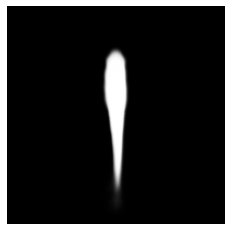

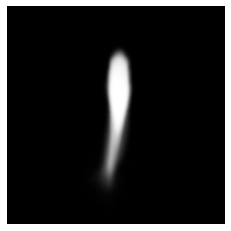

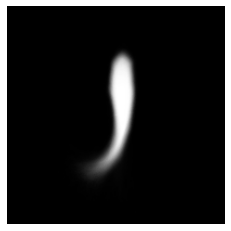

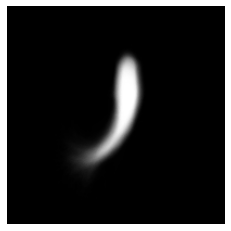

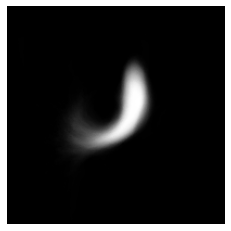

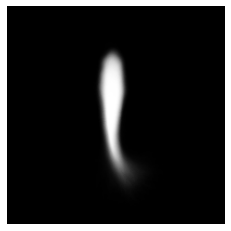

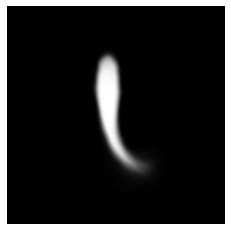

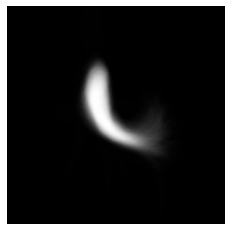

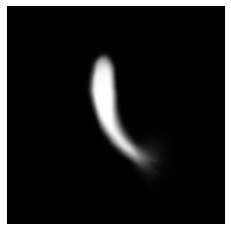

(9, 40401)

In [36]:

init_cen = []
cenlist = os.listdir(os.path.join(savepath, "init_cen"))
cenlist.sort()
for file in cenlist:
    img = cv2.imread(os.path.join(savepath, "init_cen", file), cv2.IMREAD_GRAYSCALE)
    plt.imshow(img, plt.cm.gray)
    plt.axis('off')
    plt.show()
    init_cen.append(img.flatten()>200)
    
init_cen = np.array(init_cen)
init_cen.shape

In [37]:
from sklearn.cluster import KMeans

n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, algorithm="elkan", init="k-means++", tol=1e-10, n_init=20)
kmeans.fit(pca_sks)
labels = kmeans.predict(pca_sks)
centers = kmeans.cluster_centers_

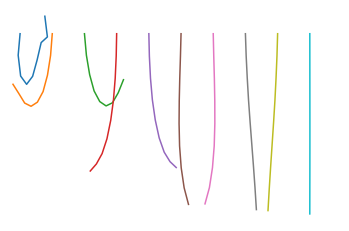

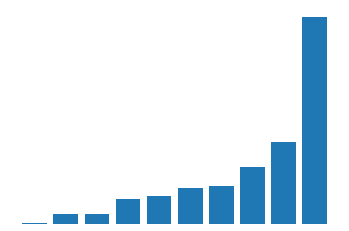

In [38]:

nums, bins = np.histogram(labels, bins=np.arange(n_clusters+1)-0.5)
ords = np.argsort(nums)

for s, pcas in enumerate(centers[ords]):
    sks = np.dot(pcas, pca.components_)
    sk=[np.array([0,-1])]
    for an in sks:
        M = get_rot_M(an).T
        sk.append(sk[-1]+np.dot(M,u))
    sk = np.array(sk)
    plt.plot(sk[:,0]+s*5,sk[:,1])
    n+=1
plt.axis('off')
plt.xlim([-2, n_clusters*5])
plt.show()
plt.bar(bins[:-1], nums[ords])
plt.axis('off')
plt.show()

0


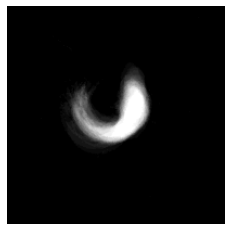

1


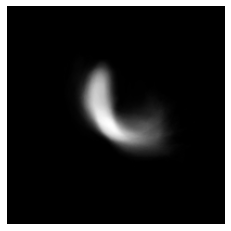

2


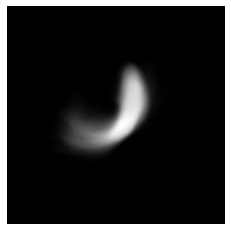

3


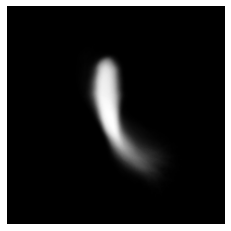

4


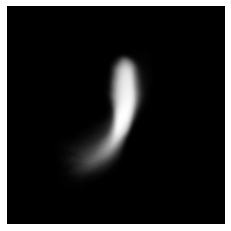

5


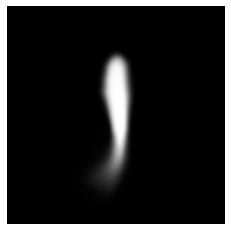

6


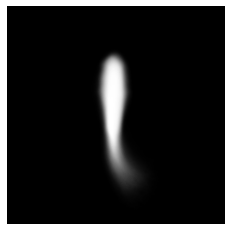

7


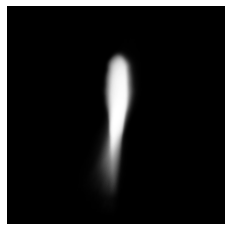

8


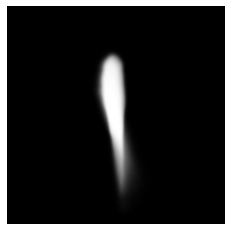

9


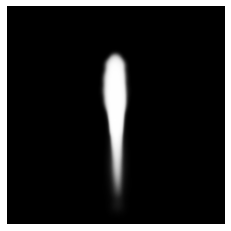

In [39]:
cen_imgs = np.zeros((n_clusters, 201, 201), dtype='int')
for s, label in enumerate(labels[:len(rot_imgs)]):
    cen_imgs[label] += rot_imgs[s]
for s, img in enumerate(cen_imgs[ords]):
    cen_imgs[s] = (img/nums[ords[s]]).astype('uint8')
    print(s)
    #cv2.imwrite(os.path.join(savepath,f"centers_{s}.png"), img*255)
    plt.imshow(cen_imgs[s], plt.cm.gray)
    plt.axis('off')
    plt.show()


In [40]:
print(len(rot_imgs), len(labels), len(poses), len(ori_sks))

23423 23423 23423 23423


# genrate the vidoe which replace by centers

In [41]:

video.release()
#cv2.VideoWriter_fourcc(*'MPEG')
video = cv2.VideoWriter(os.path.join(savepath, "cen_video.avi"), cv2.VideoWriter_fourcc(*'MPEG'),
                        40, (201, 201), isColor=False)
for label in labels[:len(poses)]:
    video.write(cen_imgs[label].astype('uint8'))
video.release()

# encode the speed(distance) and angle
注意index 從 1:-1

<ipython-input-42-0de887badb84>:11: RuntimeWarning: invalid value encountered in true_divide
  a = v/np.linalg.norm(v, ord=2)


array([-3.53429174, -2.74889357, -1.96349541, -1.17809725, -0.39269908,
        0.39269908,  1.17809725,  1.96349541,  2.74889357])

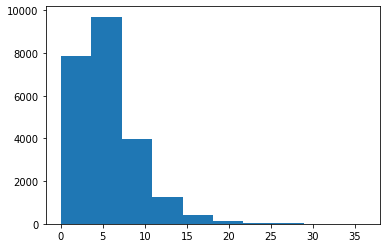

In [42]:
h_an = []
v_an = []
distes = []
poses = np.array(poses)

s=1
for pos in tqdm(poses[1:-1]):
    v = (poses[s+1]-poses[s])
    distes.append(np.linalg.norm(v))
    
    a = v/np.linalg.norm(v, ord=2)
    b = np.array([1,0])
    
    #等邀三角只要知道第三邊長c就可以算出角度，但如要知道旋轉的方向則須判別兩向量正負號
    #sin(angle) = a[1]b[0]-a[0]b[1]
    c = a-b
    angle = 2*np.arcsin(np.linalg.norm(c/2))
    if a[1]<0:# counterclockwise is positive
        angle = -angle
    v_an.append(angle)
    
    sk = ori_sks[s]
    v1 = sk[0]-sk[2]
    a = v1/np.linalg.norm(v1, ord=2)
    b = np.array([1,0])
    
    #等邀三角只要知道第三邊長c就可以算出角度，但如要知道旋轉的方向則須判別兩向量正負號
    #sin(angle) = a[1]b[0]-a[0]b[1]
    c = a-b
    angle = 2*np.arcsin(np.linalg.norm(c/2))
    if a[1]<0:# counterclockwise is positive
        angle = -angle
    h_an.append(angle)
    s+=1
plt.hist(distes)
dis_bins = [0,2,5,8,40]
an_bins = np.array([-1, -3/4, -1/2, -1/4, 0, 1/4, 1/2, 3/4, 1])-1/8
an_bins = an_bins*np.pi
an_bins



doing embedding

In [43]:
codes = []
code_len = 4*8*8*n_clusters
mapping = np.arange(code_len).reshape(4,8,8,n_clusters)
for s, pos in enumerate(tqdm(poses[1:-1])):
    dis_code = 0
    for bins in dis_bins[1:]:
        if distes[s] < bins:
            break
        dis_code+=1
    if dis_code >= 4:
        print("out of range : ", distes[s])
    
    an_code = 0
    for bins in an_bins[1:]:
        if h_an[s]<bins:
            break
        an_code += 1
    if an_code == 8:
        an_code=0
    if an_code >= 8:
        print("out of range : ", h_an[s])
        
    v_an_code = 0
    for bins in an_bins[1:]:
        if v_an[s]<bins:
            break
        v_an_code += 1
    if v_an_code == 8:
        v_an_code=0
    if v_an_code >= 8:
        print("out of range : ", v_an[s])
        
    codes.append(mapping[dis_code, an_code, v_an_code, labels[s]])

invers_map = []
for d in range(4):
    for h_a in range(8):
        for v_a in range(8):
            for l in range(n_clusters):
                invers_map.append((d, h_a, v_a, l))
invers_map = np.array(invers_map)

c2dis = [1,3,5,13]
c2an = np.array([-1, -3/4, -1/2, -1/4, 0, 1/4, 1/2, 3/4, 1])*np.pi

In [268]:
len(set(codes))
np.save("fish_mur2.npy", codes)

In [285]:
new_seq = np.load("fish_murme2.npy")
print(len(new_seq))

12001


In [44]:
video.release()
#cv2.VideoWriter_fourcc(*'MPEG')
video = cv2.VideoWriter(os.path.join(savepath, "real_video.avi"), 0 #cv2.VideoWriter_fourcc(*'MPEG')
                        , 40, (2000, 2000), isColor=False)
pos = np.array([1000,1000])
back = np.zeros((2000,2000), dtype='uint8')
u = np.array([0,-1])
for v, h_an, v_an ,label in tqdm(invers_map[codes]):
    M = cv2.getRotationMatrix2D((100, 100), -c2an[h_an]/(np.pi)*180, 1)
    dis = np.dot(get_rot_M(c2an[v_an]), u)
    dis = dis*c2dis[v]
    rotated = cv2.warpAffine(cen_imgs[label].astype('uint8'), M, (201,201))
    #print(c2dis[v], c2an[v_an]/np.pi*180, dis.astype(np.int), pos)
    video.write(glue_img(rotated, (pos[1],pos[0]), back))
    pos = pos+dis.astype(np.int)
    
    if pos[0]>2000:
        pos[0] = 0
    if pos[0]<0:
        pos[0]=2000
    if pos[1]>2000:
        pos[1] = 0
    if pos[1]<0:
        pos[1]=2000
video.release()

(-0.5, 200.5, 200.5, -0.5)

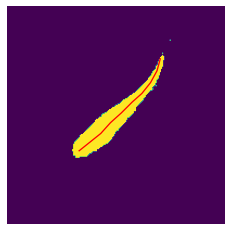

In [45]:
s = 17
plt.imshow(cutting_img(imgs[s], (120,120), 100))
plt.plot(*np.flip(ori_sks[s], axis=1).T, lw=1.3, color='r')
plt.axis('off')

In [46]:
set(codes)

{0,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 10,
 12,
 13,
 14,
 16,
 17,
 18,
 21,
 22,
 23,
 24,
 25,
 27,
 28,
 30,
 31,
 32,
 34,
 35,
 37,
 38,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 50,
 52,
 54,
 55,
 56,
 57,
 58,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 70,
 71,
 72,
 73,
 74,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 84,
 85,
 86,
 87,
 88,
 90,
 91,
 92,
 93,
 94,
 96,
 97,
 98,
 100,
 101,
 102,
 103,
 104,
 106,
 107,
 108,
 112,
 113,
 115,
 116,
 120,
 121,
 122,
 123,
 126,
 127,
 128,
 130,
 132,
 134,
 135,
 137,
 138,
 140,
 141,
 142,
 143,
 144,
 145,
 147,
 148,
 150,
 151,
 154,
 155,
 156,
 157,
 158,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 175,
 176,
 177,
 178,
 180,
 181,
 182,
 183,
 185,
 186,
 187,
 188,
 190,
 192,
 193,
 196,
 197,
 198,
 200,
 201,
 202,
 203,
 205,
 206,
 207,
 208,
 211,
 212,
 213,
 214,
 216,
 217,
 218,
 220,
 221,
 222,
 223,
 224,
 225,
 226,
 227,
 228,
 230,
 234,
 235,
 237,
 238,
 240,
 241,
 

In [47]:
## calculate the entropy of different length of alphbet --> the estimated entropy

def En_of_lens(series:list, **kwargs):
    L = len(series)
    max_len = kwargs.pop('max_len', np.ceil(np.log2(L)))
    
    ser2set, map_series, counts = np.unique(series ,return_inverse=True, return_counts=True, axis=0)
    ens = [np.log2(L)-np.sum([su/L*np.log2(su) for su in counts])]
    
    for n in range(1, max_len):
        
        #print(len(ser2set), map_series)
        temp = np.concatenate((np.stack((map_series[:-n], series[n:]), axis=-1),
                               np.stack((map_series[-n:], series[:n]), axis=-1)), axis=0)

        ser2set, map_series, counts = np.unique(temp ,return_inverse=True, return_counts=True, axis=0)
        ens.append((np.log2(L)-np.sum([su/L*np.log2(su) for su in counts]))/(n+1))
    return ens

1013561


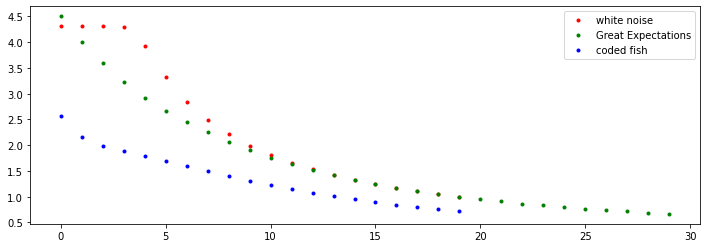

In [53]:
text_as_int = np.load("text_as_int.npy")
test = np.random.randint(20, size=int(1e6))
plt.figure(figsize=(12,4))
plt.plot(En_of_lens(test, max_len=20), 'r.', label="white noise")
plt.plot(En_of_lens(text_as_int, max_len=30), 'g.', label="Great Expectations")
plt.plot(En_of_lens(labels, max_len=20), 'b.', label="coded fish")
plt.legend()
print(len(text_as_int))

In [383]:

ser2set = {value: s for s, value in enumerate(set(codes))}
map_series = list(map(lambda x: ser2set[x] , codes))

In [425]:
temp = np.concatenate((np.stack((map_series[0:-1], map_series[1:]), axis=-1), np.stack((map_series[-1:], map_series[:1]), axis=-1)), axis=0)

In [427]:
un, invers, counts = np.unique(temp ,return_inverse=True, return_counts=True, axis=0)
print(invers[:10], map_series[:10], un[invers[0]])

[5905 3099 2996 2959 3102 3098 2959 3098 2959 3102] [1020, 639, 636, 631, 639, 639, 631, 639, 631, 639] [1020  639]


In [397]:
temp = np.stack()

'1.19.5'